<a href="https://colab.research.google.com/github/MichiganDataScienceTeam/F25-Shazam/blob/main/notebooks/week1_audio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install numpy matplotlib librosa scipy yt-dlp

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import librosa
import scipy

## Terminology

Explain Frequency, discretization of audio:

1 Hertz = 1 vibration / second 

vibration of air particles

bit depth: number of bits used to store each sample

sample rate: number of samples per second (Hz)

time is digitized using the sample rate, amplitude is digitized using bit depth

$\mathrm{bit rate} = \mathrm{sr}\times\mathrm{bit depth}\times\textrm{number of channels}$

mp3 files are measured in bit rate since they do not store the associated bit depths

The sampling interval is defined as the reciprocal of the sampling rate, and it represents the time duration between two consecutive samples in a discrete time signal. If the sampling rate is 44100 times per second, then the sampling interval is 1/44100.


try different values of `sample_rate` and `freq_Hz`

In [ ]:
# frequency of the audio signal
freq_Hz = 5

# rate at which audio is being sampled
sample_rate_Hz = 10

x_continuous = np.linspace(0, 1, 1000, endpoint=False)
y_continuous = np.cos(freq_Hz * 2*np.pi*x_continuous)

x_discrete = np.linspace(0, 1, sample_rate_Hz, endpoint=False)
y_discrete = np.cos(freq_Hz * 2*np.pi*x_discrete)

plt.plot(x_continuous, y_continuous)
plt.scatter(x_discrete, y_discrete, color="red", s=50)
plt.xlabel("Time (s)")
plt.grid()


## Good to Know Sampling Theorem:

If a signal contains no frequencies higher than $f_\mathrm{max}$, then the signal can be perfectly reconstructed when sampled at a rate $sr > 2f_\mathrm{max}$. In other words, the maximum reconstructable frequency is strictly less than $sr/2$. This is called the Nyquist-Shannon sampling theorem.

Explain aliasing briefly

In [ ]:
sample_rate_Hz = 2

freq_Hz = 5

freq_reconstructable_up_to = sample_rate_Hz / 2

x_continuous = np.linspace(0, 1, 1000, endpoint=False)
y_continuous = np.cos(freq_Hz * 2*np.pi*x_continuous)

x_undersampled = np.linspace(0, 1, 1000, endpoint=False)
y_undersampled = np.cos(freq_reconstructable_up_to * 2*np.pi*x_undersampled)

x_discrete = np.linspace(0, 1, sample_rate_Hz, endpoint=False)
y_discrete = np.cos(freq_Hz * 2*np.pi*x_discrete)

plt.plot(x_continuous, y_continuous)
plt.plot(x_undersampled, y_undersampled, color="red", linestyle="--")
plt.scatter(x_discrete, y_discrete, color="red", s=50)
plt.xlabel("Time (s)")
plt.grid()

## Working with Audio Data

In [ ]:
import yt_dlp

# add any youtube video url here, 
# copied from browser address bar
youtube_url = ""


ydl_opts = {
        'format': 'bestaudio/best',
        'outtmpl': "sample_ytdlp.%(ext)s",  # output file
        'postprocessors': [{
            'key': 'FFmpegExtractAudio',
            'preferredcodec': 'wav',       # save as wav file
        }],
        #'cookiefile': 'cookies.txt',
    }
with yt_dlp.YoutubeDL(ydl_opts) as ydl:
    ydl.download([youtube_url])

audio_path = "sample_ytdlp.wav"


In [ ]:
#audio_path = "sample_ytdlp.wav"
audio_path = "sample.wav"

audio, sr = librosa.load(audio_path, sr=None)  # sr=None uses the file's sampling rate
print(f"sample rate = {sr} Hz")

plt.figure(figsize=(12, 4))
plt.plot(audio)
plt.title("Waveform of Audio")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.show()

print("audio is digitally represented as a numpy.ndarray:")
audio

In [ ]:
# Resampling:
# internally, downsampling (reducing the sample rate) uses a low pass filter to remove higher frequency components to avoid aliasing (Sampling Theorem)
# then keeps specific samples using a sample step size of (old_sr/new_sr), first upsampling via interpolation if old_sr/new_sr is not an integer
sr = 11_025
audio, sr = librosa.load(audio_path, sr=sr)

# Question: how would you plot just the first 10 seconds of an audio file?

plt.figure(figsize=(12, 4))
plt.plot(audio, lw=0.3)
plt.scatter(np.arange(len(audio)), audio, s=2, color="red")
plt.title("Resampled Audio Waveform")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.show()
audio

## Next week: visualizing frequency

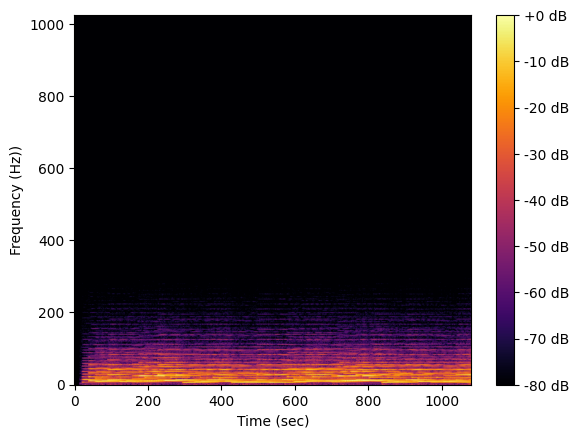

In [21]:
audio, sr = librosa.load("sample.wav", sr=None) 

s = np.abs(librosa.stft(audio))
s_db = librosa.amplitude_to_db(s, ref=np.max)

im = plt.imshow(s_db, cmap="inferno", aspect="auto", 
                origin="lower")
plt.colorbar(im, format="%+2.0f dB")
plt.xlabel("Time (sec)")
plt.ylabel("Frequency (Hz))")
plt.show()

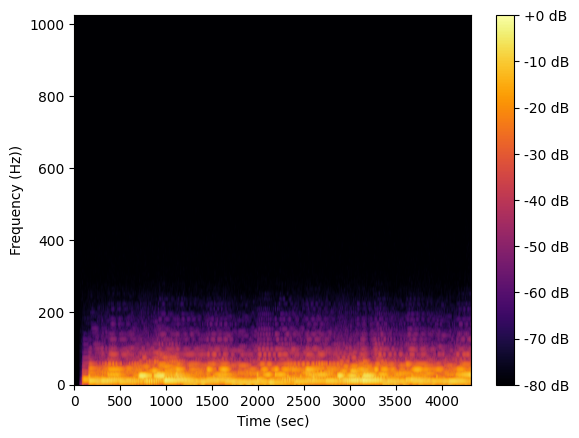

In [20]:
audio, sr = librosa.load("sample.wav", sr=None) 

freq_scipy, time_scipy, spectrum_scipy = scipy.signal.stft(
    audio, fs=sr, window="hann", nfft=2**11
)

spectrum_scipy_db = librosa.amplitude_to_db(np.abs(spectrum_scipy), ref=np.max)

im = plt.imshow(spectrum_scipy_db, cmap="inferno", aspect="auto", 
                origin="lower")
plt.colorbar(im, format="%+2.0f dB")
plt.xlabel("Time (sec)")
plt.ylabel("Frequency (Hz))")
plt.show()
